In [6]:
# This notebook runs from the projects root directory.
import os
PROJECT_ROOT_DIRECTORY = 'senior_project'
while os.path.basename(os.getcwd()) != PROJECT_ROOT_DIRECTORY:
    os.chdir(os.pardir)
print('Current working directory:', os.getcwd())

Current working directory: c:\Users\pavan\Desktop\senior_project


## Setup

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import yfinance as yf

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import risk_matrix
from pypfopt.efficient_frontier import EfficientFrontier

from environments.discrete_env_v2 import PortfolioManagementEnv
from experiments.utils import evaluate_results

In [8]:
TICKERS = ['AXP', 'AAPL', 'BA', 'GS', 'INTC', 'JNJ', 'KO', 'NKE', 'PG', 'DIS']
RETURN_COLS = ['RF_RETURN'] + [f'{ticker}_RETURN' for ticker in TICKERS]
FEATURE_COLS = [f'{ticker}_RETURN' for ticker in TICKERS]

In [9]:
df = pd.read_csv('data/dow_10_returns.csv', index_col=0, parse_dates=True)
df.head(3)

,RF_RETURN,AXP_RETURN,AAPL_RETURN,BA_RETURN,GS_RETURN,INTC_RETURN,JNJ_RETURN,KO_RETURN,NKE_RETURN,PG_RETURN,DIS_RETURN
2010-01-04,0.000150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-05,0.000146,-0.002199,0.001729,0.032752,0.017680,-0.000479,-0.011595,-0.012097,0.003979,0.000327,-0.002494
2010-01-06,0.000148,0.016165,-0.015906,0.030334,-0.010674,-0.003354,0.008133,-0.000355,-0.006097,-0.004743,-0.005314


## Baseline: Max Sharpe Ratio Strategy

c:\Users\pavan\anaconda3\envs\rl_env\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\pavan\anaconda3\envs\rl_env\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Value error count: 28


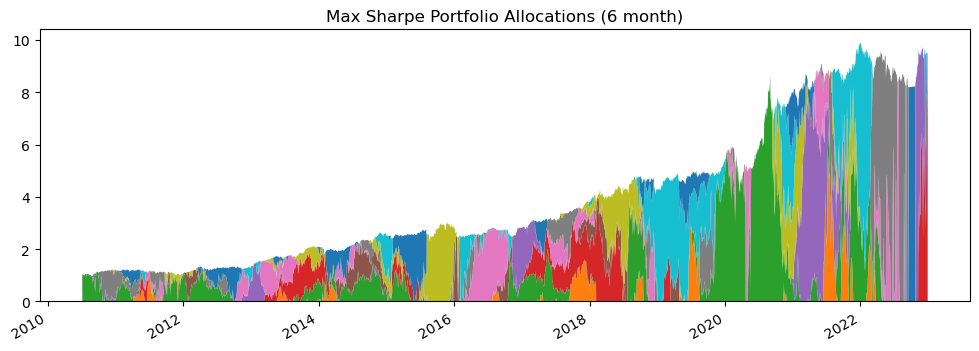

In [10]:
WINDOW_SIZE = 126 # half a trading year

np.random.seed(5)
value_error_count = 0
env = PortfolioManagementEnv(df, RETURN_COLS, feature_cols=FEATURE_COLS, starting_balance=1, episode_length=-1, window_size=WINDOW_SIZE)

obs, done = env.reset(), False
while not done:
    
    observation_df = pd.DataFrame(obs.reshape(-1, env.NUM_ASSETS), columns=FEATURE_COLS)
    annualized_mean_return = mean_historical_return(observation_df, returns_data=True)
    annualized_covariance = risk_matrix(observation_df, returns_data=True, method='sample_cov')
    ef = EfficientFrontier(annualized_mean_return, annualized_covariance)
    
    try:
        weights = ef.max_sharpe(risk_free_rate=(1+env.RETURNS[env.current_index,0])**252-1)
        cleaned_weights = ef.clean_weights()
        env.current_allocations = np.insert(np.array([w for w in cleaned_weights.values()]), 0, 0)
    
    except ValueError: # for when none of the assets must have an expected return exceeding the risk-free rate
        env.current_allocations = np.insert(np.zeros(len(FEATURE_COLS)), 0, 1) # invest everything into the risk free rate
        value_error_count += 1
    
    obs, reward, done, info = env.step(env.NUM_ASSETS) # do nothing

print(f'Value error count: {value_error_count}')
env.render(title='Max Sharpe Portfolio Allocations (6 month)')
env.close()

## Baseline: Dow Jones Industrial Average (DJIA)

In [11]:
dija_returns = yf.download('^DJI', start = df.index[0], end = df.index[-1], interval = '1d')['Adj Close'].pct_change(1)

[*********************100%***********************]  1 of 1 completed


## Creating and saving `results_df`

In [12]:
results_df = pd.DataFrame(index=df.index)
results_df['Baseline DJIA'] = dija_returns
results_df['Baseline Max Sharpe'] = env.get_portfolio_returns()
results_df.head(3)

,Baseline DJIA,Baseline Max Sharpe
2010-01-04,NaN,NaN
2010-01-05,-0.001128,NaN
2010-01-06,0.000157,NaN


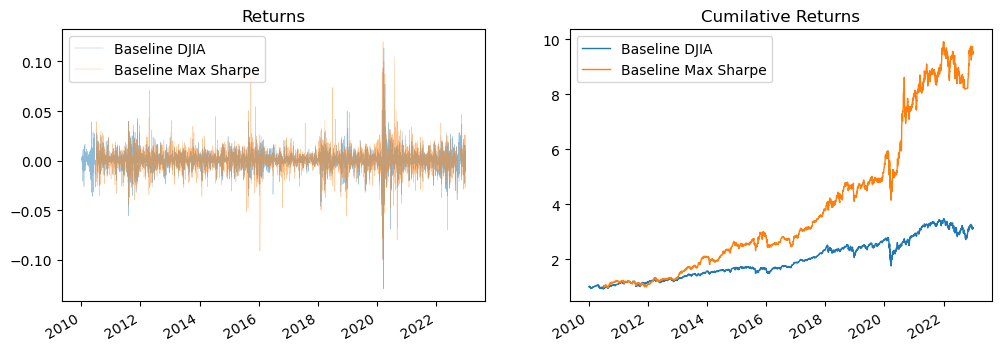

In [13]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
results_df.plot(ax = axes[0], lw=0.3, alpha=0.5, title='Returns');
(results_df+1).cumprod().plot(ax = axes[1], lw=1, alpha=1, title='Cumilative Returns');

<span style="color:red">**(RUN ONCE)**</span>

In [14]:
# results_df.to_csv('experiments/results_df.csv')

In [15]:
results_df.to_csv('experiments/baselines_df.csv')

## Evaluate Results Function

In [16]:
def evaluate_results(results_df, plot_metrics=[]):
    """
    Evaluate `results_df` on a common set of metrics.
    """
    metrics = {}
    metrics['Annualized Mean Return'] = (1+results_df).prod()**(252/len(df))-1
    metrics['Annualized Risk'] = np.sqrt(results_df.var()*252)
    metrics['Sharpe Ratio'] = metrics['Annualized Mean Return'] / metrics['Annualized Risk']
    
    if len(plot_metrics)>0:
        fig, axes = plt.subplots(1, len(plot_metrics), figsize=(len(plot_metrics)*4, 4))
        for i,metric in enumerate(plot_metrics):
            metrics[metric].plot.bar(ax=axes[i], title=metric, rot=0, color='#F4C430')
    
    return metrics

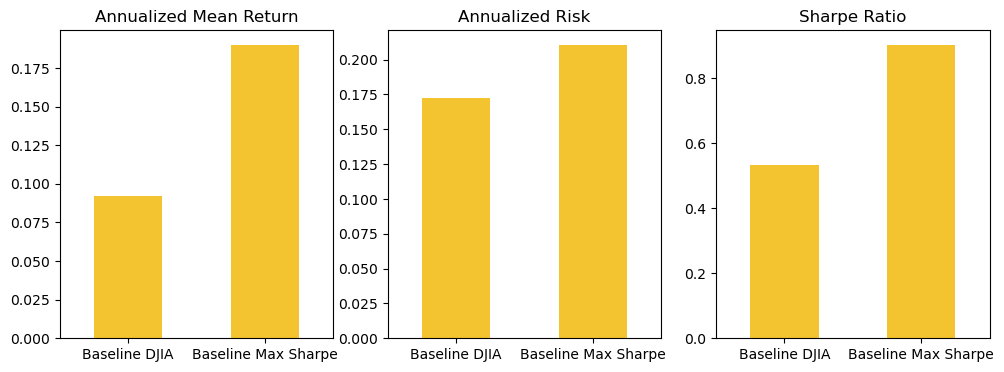

In [17]:
# example
metrics = evaluate_results(results_df, plot_metrics=['Annualized Mean Return', 'Annualized Risk', 'Sharpe Ratio'])